<a href="https://colab.research.google.com/github/crux82/CLiC-it_2023_tutorial/blob/main/CLiC_it_2023_tutorial_ExtremITA_2_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CLiC-it 2023 Tutorial
# Large Language Models and How to Instruction Tune Them (in a Sustainable Way) - Step 3

**Authors**: C.D. Hromei & D. Croce

This is an implementation for training and using a Large Language Model (based on [LLaMA](https://ai.meta.com/blog/large-language-model-llama-meta-ai/)) with instructions in order to solve the linguistic tasks of [EVALITA](https://www.evalita.it/campaigns/evalita-2023/). In this lab, we will see how to encode datasets from any format to a sequence to sequence format, train the model using [Q-LoRA](https://arxiv.org/abs/2305.14314), perform the inference using the previous trained model for generating answers to instructions, and finally, how to encode back the data to the original format.. all of it using the only available *T4 GPU with 15GB from Google Colab*.

The tutorial is split into 4 steps, reflecting the aforementioned process:
- Step 1 - Encoding the data
- Step 2 - Training the LLaMA model
- **Step 3 - Inference: generating answers**
- Step 4 - Deconding the data

# Index:
1. Introduction, Workflow and Objectives
2. Preliminary steps
3. Loading the model
4. Generating answers
5. Saving the data in the 4-column format

## Step 3 - Inference: generating answers

In this Notebook we will see how to use the model we trained earlier for generating answers on new data, maybe a test set. Here we will load it from Huggingface (but if you have saved it on your colab it's almost the same), we will se some examples and we will ask the model to answer.

## Input
The "input" of the Notebook is the previously trained model, that we can load either from Google Drive or from HuggingFace.

## Output
The "output" will be the generations for the CLinkaRT task, in the 4-columns format.

## Preliminary Steps:

1.   Runtime SetUp
2.   Install Packages

### RunTime SetUp

Please make sure you are using the runtime environment according to the following settings:
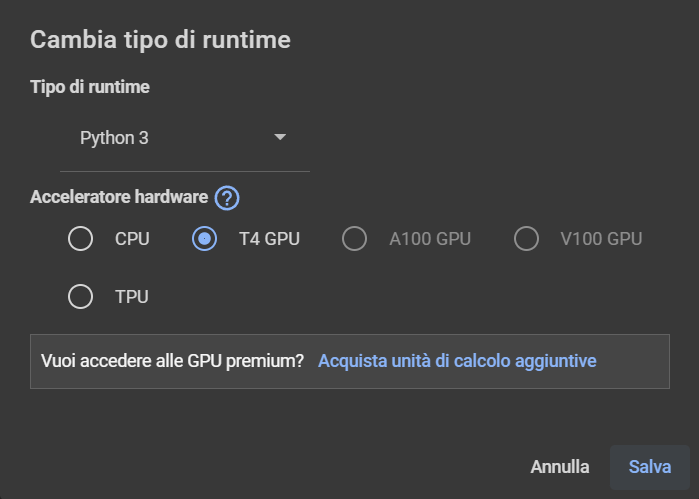

## Install packages

Tip: An initial "!" allows you to execute the rest if the code in the line as on the OS shell

In [1]:
# do not know why, but you need to:
#   1. run this once
#   2. comment the pip install command using "#"
#   3. restart the kernel
# and it works.. Colab is strange :D

! pip install peft
! pip install sentencepiece
! pip install accelerate
! pip install bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.4 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import pandas as pd

from peft import PeftModel
from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig

### Handle external data:
<a href="https://colab.research.google.com/notebooks/io.ipynb">Here</a> you can find a guide on how to handle external data with Google Colab. We will import some file from my personal Google Drive.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# change this to match your path
data_path = "./drive/MyDrive/Colab Notebooks/PhD/CLiC-it 2023 tutorial/data"

Mounted at /content/drive


### Utils code for generating text in the ad hoc form for each task

In [5]:
def task_to_prompt(task: str):
    if task == "acti_a":
        return "In questo testo si parla di una cospirazione? Rispondi sì o no."
    elif task == "acti_b":
        return "Di quale teoria cospirazionista parla questo testo, tra \"Covid\", \"Qanon\", \"Terrapiattista\", \"Russia\"?"
    elif task == "clinkart":
        return "Trova i risultati dei test e delle misurazioni nel testo. Per ogni risultato, scrivi \"[BREL]\", seguito dal risultato seguito da \"[SEP]\", seguito dal test, seguito da \"[EREL]\". Se non trovi nessun risultato, scrivi \"[NOREL]\"."
    elif task == "discotex_1":
        return "Le due frasi seguenti, separate da \"[SEP]\", sono coerenti tra loro? Rispondi sì o no."
    elif task == "discotex_2":
        return "Quanto è coerente questa frase, su una scala da 0 a 5?"
    elif task == "emit_a":
        return "Quali emozioni sono espresse in questo testo? Puoi scegliere una o più emozioni tra \"rabbia\", \"anticipazione\", \"disgusto\", \"paura\", \"gioia\", \"amore\", \"tristezza\", \"sorpresa\", \"fiducia\", o \"neutro\"."
    elif task == "emit_b":
        return "Di cosa parla il testo, tra \"direzione\", \"argomento\", \"entrambi\", \"non specificato\"?"
    elif task == "emotivita":
        return "Scrivi quanta valenza è espressa in questo testo su una scala da 1 a 5, seguito da quanto stimolo è espresso in questo testo su una scala da 1 a 5, seguito da quanto controllo è espresso in questo testo su una scala da 1 a 5."
    elif task == "geolingit":
        return "Scrivi la regione di appartenenza di chi ha scritto questo testo, seguito dalla latitudine, seguita dalla longitudine."
    elif task == "haspeede":
        return "In questo testo si esprime odio? Rispondi sì o no."
    elif task == "hodi_a":
        return "In questo testo si esprime odio omotransfobico? Rispondi sì o no."
    elif task == "hodi_b":
        return "Con quali parole l'autore del testo seguente esprime odio omotransfobico? Separa le sequenze di parole con [gap]."
    elif task == "langlearn":
        return "Questi due testi separati da [SEP] sono presentati nell'ordine in cui sono stati scritti? Rispondi sì o no."
    elif task == "multifakedetective":
        return "L'evento riportato nel testo è \"certamente vero\", \"probabilmente vero\", \"probabilmente falso\", o \"certamente falso\"?"
    elif task == "nermud":
        return "Scrivi le menzioni di entità nel testo, indicandone il tipo: [PER] (persona), [LOC] (luogo), [ORG] (organizzazione)."
    elif task == "politicit":
        return "Scrivi se l'autore del testo è \"uomo\" o \"donna\", seguito dalla sua appartenenza politica tra \"destra\", \"sinistra\", \"centrodestra\", \"centrosinistra\"."
    elif task == "wicita":
        return "La parola compresa tra [TGTS] e [TGTE] ha lo stesso significato in entrambe le frasi? Rispondi sì o no."
    else:
        return "task sconosciuto"


 ################ GENERATE METHODS ################
def generate_prompt_pred(instruction, input_):
    return f"""Di seguito è riportata un'istruzione che descrive un task, insieme ad un input che fornisce un contesto più ampio. Scrivete una risposta che completi adeguatamente la richiesta.
### Istruzione:
{instruction}
### Input:
{input_}
### Risposta:"""

# In inferenza mettere codice per come caricare sia da drive che da huggingface (quello di prima)

In [6]:
bits = "4" #@param [4, 8, "full"]

In [7]:
tokenizer = LlamaTokenizer.from_pretrained("yahma/llama-7b-hf")
tokenizer.padding_side = "left"
tokenizer.pad_token_id = (0)

# base model here, choose between 4, 8 bits or full precision
if bits == "8":
  model = LlamaForCausalLM.from_pretrained(
    "sag-uniroma2/extremITA-Camoscio-7b",
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map="auto",
  )
elif bits == "4":
  model = LlamaForCausalLM.from_pretrained(
    "sag-uniroma2/extremITA-Camoscio-7b",
    load_in_4bit=True,
    torch_dtype=torch.float16,
    device_map="auto",
  )
else:
  model = LlamaForCausalLM.from_pretrained(
    "sag-uniroma2/extremITA-Camoscio-7b",
    torch_dtype=torch.float16,
    device_map="auto",
  )

# Peft model with LoRA
model = PeftModel.from_pretrained(
  model,
  # f"{data_path}/extremITLLaMA", # this is my "local" path for loading the model just trained
  "sag-uniroma2/extremITA-Camoscio-7b-adapters", # this is how I load the adapters of ExtremITA from HuggingFace, for illustrations purpose
  torch_dtype=torch.float16,
  device_map="auto",
)

tokenizer_config.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/591 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00039.bin:   0%|          | 0.00/396M [00:00<?, ?B/s]

pytorch_model-00002-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00003-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00004-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00005-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00006-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00007-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00008-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00009-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00010-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00011-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00012-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00013-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00014-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00015-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00016-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00017-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00018-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00019-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00020-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00021-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00022-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00023-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00024-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00025-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00026-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00027-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00028-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00029-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00030-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00031-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00032-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00033-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00034-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00035-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00036-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00037-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00038-of-00039.bin:   0%|          | 0.00/304M [00:00<?, ?B/s]

pytorch_model-00039-of-00039.bin:   0%|          | 0.00/262M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/39 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/404 [00:00<?, ?B/s]

adapter_model.bin:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

In [8]:
BS = 1

CUTOFF_LEN = 1024
CUT_INPUT_CHAR_LENGTH = 1500
MAX_NEW_TOKENS = 256


generation_config = GenerationConfig(
  temperature=0.2,
  top_p=0.75,
  top_k=40,
  num_beams=4,
)

In [9]:
model.config.pad_token_id = tokenizer.pad_token_id = 0
model.config.bos_token_id = tokenizer.bos_token_id = 1
model.config.eos_token_id = tokenizer.eos_token_id = 2

model.eval()
if torch.__version__ >= "2":
    model = torch.compile(model)

In [10]:
inputs = [
  ["1", "emit_a", "Ora siamo tutti sollevati #IMedici", "fiducia"],
  ["2", "emotivita", "Non pretendo che la nostra fosse stata una relazione perfetta, solo meravigliosa.", "4.0 4.0 3.3"],
  ["3", "politicit", "[POLITICIAN] Riforma [POLITICIAN] catasto è più tasse sulla casa per tutti. Evitiamo gli alibi delle case “fantasma” da accatastare e [POLITICIAN] quelle in centro a valore [POLITICIAN] periferia perché si possono sistemare già con [POLITICIAN] normativa ATTUALE! @politician @politician @user @politician @politician State penalizzando un settore che è trainante [POLITICIAN] PIL ed è sempre cresciuto dal dopoguerra ad oggi! stai sereno informati almeno sui lavori parlamentari: è il Governo che ha minacciato [POLITICIAN] dimettersi se non si approvava [POLITICIAN] riforma [POLITICIAN] catasto, giusto perché è solo una mappatura! Solo chi non ha Onesta intellettuale non vede MAGGIORI TASSE PER TUTTI! cioè stiamo penalizzando l’unico settore che dal dopoguerra ad oggi ha visto non solo una crescita continua ma essere trainante [POLITICIAN] PIL italiano…brillanti davvero brillanti!", "uomo destra destra"],
  ["4", "geolingit", "[USER] [USER] Si amico mio. Te accolli. Altro che sette. Saranno minimo na ventina a esse boni.", "[regione] Lazio [geo] 41.89 12.54"],
  ["5", "langlearn", "Mi chiamo Francesco ho dieci anni e frequento la scuola Sant’Agata e sto in 1 a.Sono alto circa centoquaranta centimetri. Ho capelli neri, orecchie un po a sventola ciglie lunghe, sopracciglia corte, viso ovale, un po ciccione e dei occhi neri. Quando mi arrabbio lancio tutto per aria e se proprio mi arrabbio faccio la mia casa “sottosopra” cosa che accade raramente. Io di solito mi vesto con i jeans e una camicia. [SEP] Ciao io sono Francesca vi devo raccontare un fatto strano, ora ve lo racconto. Ero a Anzio con i miei amici naturalmente c’era anche l’amico che odiavo perché a mia mamma era simpatico. Un giorno eravamo andati al mare e stavamo nuotando, a un certo punto viene un onda gigante anzi tre, perché lontano stava passando una crociera che stava andando a Ponza.", "sì"],
  ["6", "haspeede", "Fondo assunzioni straordinarie ha una dotazione finanziaria rilevante #leggedibilancio", "no"],
  ["7", "hodi_a", "@user_abcdefghij Speriamo che si caghino sotto", "no"],
  ["8", "multifakedetective", "#flowers #lovers Fate l'amore non fate la guerra. Marc Chagall, 'Il mazzo di fiori degli amanti', 1926. #art #painting #marcchagall #NoWars https://t.co/XahcLle4SK", "probabilmente vero"],
  ["9", "acti_a", "Flat tax all'ungherese", "no"],
  ["10", "nermud", "infatti impegna per il futuro , essendo il suo vero proposito quello di stabilire chi delle persone ora lì presenti appartiene alla Venezia Giulia e chi no.", "[LOC] Venezia Giulia"],
  ["11_0_66", "clinkart", "Veniva documentato, inoltre, il rialzo della troponina TnT-hs (289;", "[BREL] 289 [SEP] troponina [EREL]"],
  ["12", "wicita", "La [BT1] faccia  [ET1] dura verso gli abusi insanabili , che questo « lifting » al condono si picca di mostrare , ha infatti dei precedenti tali da far nascere qualche diffidenza . [SEP] Si potrebbe leggere tanto dinamismo , volontà ed attivismo in questo film , ma ci sono le [BT2] facce  [ET2] , queste non mentono , anzi smascherano ogni ipocrisia .", "sì"],
  ["13", "discotex_1", "Potete aggiungere solo un gene? No, potete aggiungere addirittura intere vie metaboliche. Tutto questo è possibile grazie a due brillantissime genetiste. [SEP] Vorrei rassicurarvi, la maggior parte degli scienziati non vuole fare esseri umani geneticamente modificati.", "no"]
]

In [11]:
# generate prompts based on task and text
preds = []
for input in inputs:
  id = input[0]
  task = input[1]
  text = input[2]
  expected_output = input[3]

  instruction = task_to_prompt(task)
  prompt = generate_prompt_pred(instruction, text[:CUT_INPUT_CHAR_LENGTH])

  # tokenization
  tokenized_inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)

  # inference
  with torch.no_grad():
    gen_outputs = model.generate(
      **tokenized_inputs,
      return_dict_in_generate=True,
      output_scores=True,
      max_new_tokens=MAX_NEW_TOKENS
    )

    # decoding and printing
    for i in range(len(gen_outputs[0])):
      output = tokenizer.decode(gen_outputs[0][i], skip_special_tokens=True)
      if "### Risposta:" in output:
        response = output.split("### Risposta:")[1].rstrip().lstrip()
      else:
        response = "UNK"

      print(text)
      print(f"\t {expected_output} \t {response}")
      print(50*"*")

      # add here lines of clinkart for decoding later
      if task == "clinkart":
        preds.append([id, task, text, response])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Ora siamo tutti sollevati #IMedici
	 fiducia 	 fiducia
**************************************************
Non pretendo che la nostra fosse stata una relazione perfetta, solo meravigliosa.
	 4.0 4.0 3.3 	 4.0 3.5 3.8
**************************************************
[POLITICIAN] Riforma [POLITICIAN] catasto è più tasse sulla casa per tutti. Evitiamo gli alibi delle case “fantasma” da accatastare e [POLITICIAN] quelle in centro a valore [POLITICIAN] periferia perché si possono sistemare già con [POLITICIAN] normativa ATTUALE! @politician @politician @user @politician @politician State penalizzando un settore che è trainante [POLITICIAN] PIL ed è sempre cresciuto dal dopoguerra ad oggi! stai sereno informati almeno sui lavori parlamentari: è il Governo che ha minacciato [POLITICIAN] dimettersi se non si approvava [POLITICIAN] riforma [POLITICIAN] catasto, giusto perché è solo una mappatura! Solo chi non ha Onesta intellettuale non vede MAGGIORI TASSE PER TUTTI! cioè stiamo penalizzando l

In [12]:
clinkart_df = pd.DataFrame({
    "id": [x[0] for x in preds],
    "task": [x[1] for x in preds],
    "text": [x[2] for x in preds],
    "response": [x[3] for x in preds]
})

clinkart_df.to_csv(f"{data_path}/clinkart_predictions.csv", index=False)

### Next step
[Step 4 - Decoding the data](https://colab.research.google.com/drive/1HfXuwzbI6zTTC7r1AgMN-nuV6_VstWGM?usp=sharing)